In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
cd /content/drive/My Drive/NLP/SA_SSTdata

/content/drive/My Drive/NLP/SA_SSTdata


In [0]:
pip install pytreebank

  Created wheel for pytreebank: filename=pytreebank-0.2.7-cp36-none-any.whl size=37072 sha256=569df8e9e2fe67c063852bce05afa2976d4313a9474835ffc83d642719e26ce4
  Stored in directory: /root/.cache/pip/wheels/e0/b6/91/e9edcdbf464f623628d5c3aa9de28888c726e270b9a29f2368
Successfully built pytreebank


In [0]:
import pytreebank
dataset = pytreebank.load_sst()
example = dataset["train"][0]

# extract spans from the tree.
for label, sentence in example.to_labeled_lines():
	print("%s has sentiment label %s" % (
		sentence,
		["very negative", "negative", "neutral", "positive", "very positive"][label]
	))

In [0]:
# Load data
import pytreebank
import sys
import os

out_path = os.path.join(sys.path[0], 'sst_{}.txt')
dataset = pytreebank.load_sst('./raw_data')

# Store train, dev and test in separate files
for category in ['train', 'test', 'dev']:
    with open(out_path.format(category), 'w') as outfile:
        for item in dataset[category]:
            outfile.write("__label__{}\t{}\n".format(
                item.to_labeled_lines()[0][0] + 1,
                item.to_labeled_lines()[0][1]
            ))
# Print the length of the training set
print(len(dataset['train']))
# Print the length of the training set
print(len(dataset['test']))
# Print the length of the training set
print(len(dataset['dev']))
a = len(dataset['train']) + len(dataset['dev']) + len(dataset['test'])
print(a)

8544
2210
1101
11855


Text(0, 0.5, 'Label')

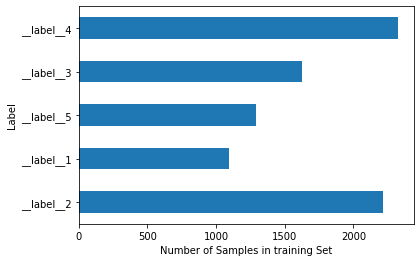

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

# Read train data
df = pd.read_csv('sst_train.txt', sep='\t', header=None, names=['truth', 'text'])

ax = df['truth'].value_counts(sort=False).plot(kind='barh')
ax.set_xlabel("Number of Samples in training Set")
ax.set_ylabel("Label")

In [0]:
import pandas as pd
# Read train data
df = pd.read_csv('../data/sst_train.txt', sep='\t', header=None, names=['truth', 'text'])
df['truth'] = df['truth'].str.replace('__label__', '')
df['truth'] = df['truth'].astype(int).astype('category')
df.head()

,truth,text
0,4,The Rock is destined to be the 21st Century 's...
1,5,The gorgeously elaborate continuation of `` Th...
2,4,Singer/composer Bryan Adams contributes a slew...
3,3,You 'd think by now America would have had eno...
4,4,Yet the act is still charming here .


In [0]:
# Use NaiveBayes

import torchtext
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from tqdm import tqdm

class NaiveBayes:
    def __init__(self, text):
        self.train_iter = train_iter
        self.test_iter = test_iter
        self.val_iter = val_iter
        self.array_like = np.zeros((train_iter.batch_size, len(text.vocab)))
        
    def binarize_occurrences(self, indices):
        occurrences = self.array_like.copy()
        for idx, entry in enumerate(indices): occurrences[idx][entry] = 1
        return occurrences

    def batch_to_input(self, batch, train = True):
        word_indices = batch.text.data.numpy().T
        x = self.binarize_occurrences(word_indices)
        if train:
            y = batch.label.data.numpy()
            return x, y
        else:
            return x

    def train_mnb(self, train_iter, val_iter, no_epochs):
        self.model = MultinomialNB(alpha=1.0, fit_prior=True)
        for epoch in tqdm(range(1, no_epochs+1)):
            for batch in train_iter:
                x, y = self.batch_to_input(batch, train = True)
                self.model.partial_fit(x, y, classes = [1,2])
            
            if epoch % 1 == 0:
                acc = self.validate(val_iter)
                print('Epoch ', epoch, '| Validation Accuracy: ', acc)
        print('Done training.')
        
    def test(self, test_iter):
        "All models should be able to be run with following command."
        upload, trues = [], []

        for batch in test_iter:
            x, y = self.batch_to_input(batch, train = False), batch.label
            probs = self.model.predict(x)
            upload += list(probs)
            trues += list(y.data)
        correct = sum([1 if i == j else 0 for i, j in zip(upload, trues)])
        accuracy = correct / len(trues)
        print('Test Accuracy: ', accuracy)
        
        with open("predictions.txt", "w") as f:
            for u in upload:
                f.write(str(u) + "\n")
                
    def validate(self, val_iter):
        y_p, y_t, correct = [], [], 0
        for batch in val_iter:
            x, y = self.batch_to_input(batch, train = False), batch.label
            probs = self.model.predict(x)[:len(y.data)]
            y_p += list(probs)
            y_t += list(y.data)
        correct = sum([1 if i == j else 0 for i, j in zip(y_p, y_t)])
        accuracy = correct / len(y_p)
        return accuracy

text = torchtext.data.Field(include_lengths = False)
label = torchtext.data.Field(sequential=False)
train, val, test = torchtext.datasets.SST.splits(text, label, filter_pred=lambda ex: ex.label != 'neutral')
text.build_vocab(train)
label.build_vocab(train)
train_iter, val_iter, test_iter = torchtext.data.BucketIterator.splits((train, val, test), batch_size=10, device=-1, repeat = False)
mnb = NaiveBayes(text)
mnb.train_mnb(train_iter, val_iter, 1)
mnb.test(test_iter)

The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
100%|██████████| 1/1 [00:02<00:00,  2.15s/it]

Epoch  1 | Validation Accuracy:  0.7981651376146789
Done training.
Test Accuracy:  0.8209774848984075


In [0]:
#  Logistic Regression
import torchtext
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torchtext.vocab import Vectors

class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes, batch_size):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes, bias = True)
        self.array_like = np.zeros((batch_size, input_size))
    
    def forward(self, x):
        output = self.linear(x)
        activated = nn.functional.sigmoid(output)
        return activated

    def predict(self, x):
        output = self.forward(x)
        logits = nn.functional.log_softmax(output, dim = 1)
        return logits.max(1)[1] + 1

    def binarize_occurrences(self, indices):
        occurrences = self.array_like.copy()
        for idx, entry in enumerate(indices): occurrences[idx][entry] = 1
        return occurrences

    def batch_to_input(self, batch, train = True):
        word_indices = batch.text.data.numpy().T
        x = self.binarize_occurrences(word_indices)
        if train:
            return Variable(torch.FloatTensor(x)), batch.label
        else:
            return Variable(torch.FloatTensor(x))
    
    def train(self, train_iter, val_iter, num_epochs, learning_rate = 1e-3, plot = False):
        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        loss_vec = []
        
        for epoch in tqdm(range(1, num_epochs+1)):
            epoch_loss = 0
            for batch in train_iter:
                x, y = self.batch_to_input(batch, train = True)
                
                optimizer.zero_grad()
                
                output = self.forward(x)
                
                loss = criterion(output, y-1)
                loss.backward()
                
                optimizer.step()
                epoch_loss += loss.data
            self.model = model
            
            loss_vec.append(epoch_loss / len(train_iter))
            if epoch % 1 == 0:
                acc = self.validate(val_iter)
                print('Epoch {} loss: {} | Valid acc: {}'.format(epoch, loss_vec[epoch-1], acc))
        if plot:
            plt.plot(range(len(loss_vec)), loss_vec)
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.show()
        print('\nModel trained.\n')
        self.loss_vec = loss_vec

    def test(self, test_iter):
        "All models should be able to be run with following command."
        upload, trues = [], []
        # Update: for kaggle the bucket iterator needs to have batch_size 10
        for batch in test_iter:
            # Your prediction data here (don't cheat!)
            x, y = self.batch_to_input(batch, train = False), batch.label
            preds = self.predict(x)
            upload += list(preds.data.numpy())
            trues += list(y.data.numpy())
            
        correct = sum([1 if i == j else 0 for i, j in zip(upload, trues)])
        accuracy = correct / len(trues)
        print('Test Accuracy:', accuracy)
        
        with open("predictions.txt", "w") as f:
            for u in upload:
                f.write(str(u) + "\n")
                
    def validate(self, val_iter):
        y_p, y_t, correct = [], [], 0
        for batch in val_iter:
            x, y = self.batch_to_input(batch, train = False), batch.label
            probs = self.model.predict(x)[:len(y.data.numpy())]
            y_p += list(probs.data.numpy())
            y_t += list(y.data.numpy())
        correct = sum([1 if i == j else 0 for i, j in zip(y_p, y_t)])
        accuracy = correct / len(y_p)
        return accuracy


text = torchtext.data.Field(include_lengths = False)
label = torchtext.data.Field(sequential=False)
train, val, test = torchtext.datasets.SST.splits(text, label, filter_pred=lambda ex: ex.label != 'neutral')
text.build_vocab(train)
label.build_vocab(train)
train_iter, val_iter, test_iter = torchtext.data.BucketIterator.splits((train, val, test), batch_size=10, device=-1, repeat = False)

model = LogisticRegression(len(text.vocab), 2, 10)
model.train(train_iter = train_iter, val_iter = val_iter, num_epochs = 11 , learning_rate = 1e-3, plot = False)
model.test(test_iter)

The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
  0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
  9%|▉         | 1/11 [00:01<00:13,  1.39s/it]

Epoch 1 loss: -0.8369014263153076 | Valid acc: 0.7052752293577982


 18%|█▊        | 2/11 [00:02<00:13,  1.45s/it]

Epoch 2 loss: -0.9692325592041016 | Valid acc: 0.7431192660550459


 27%|██▋       | 3/11 [00:04<00:12,  1.51s/it]

Epoch 3 loss: -0.9858507513999939 | Valid acc: 0.7568807339449541


 36%|███▋      | 4/11 [00:06<00:10,  1.53s/it]

Epoch 4 loss: -0.9919400811195374 | Valid acc: 0.7557339449541285


 45%|████▌     | 5/11 [00:07<00:09,  1.56s/it]

Epoch 5 loss: -0.9949523210525513 | Valid acc: 0.7580275229357798


 55%|█████▍    | 6/11 [00:09<00:07,  1.58s/it]

Epoch 6 loss: -0.9966669082641602 | Valid acc: 0.7637614678899083


 64%|██████▎   | 7/11 [00:11<00:06,  1.59s/it]

Epoch 7 loss: -0.9977269768714905 | Valid acc: 0.768348623853211


 73%|███████▎  | 8/11 [00:12<00:04,  1.60s/it]

Epoch 8 loss: -0.9984187483787537 | Valid acc: 0.7649082568807339


 82%|████████▏ | 9/11 [00:14<00:03,  1.62s/it]

Epoch 9 loss: -0.9988841414451599 | Valid acc: 0.7672018348623854


 91%|█████████ | 10/11 [00:16<00:01,  1.64s/it]

Epoch 10 loss: -0.9992055892944336 | Valid acc: 0.768348623853211


100%|██████████| 11/11 [00:17<00:00,  1.61s/it]

Epoch 11 loss: -0.9994297027587891 | Valid acc: 0.7729357798165137

Model trained.

Test Accuracy: 0.7666117517847336


In [0]:
import torchtext
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from torchtext.vocab import Vectors
from tqdm import tqdm

class CBoW(nn.Module):
    def __init__(self, input_size, num_classes, batch_size):
        super(CBoW, self).__init__()
        self.embeddings = nn.Embedding(text.vocab.vectors.size()[0], text.vocab.vectors.size()[1])
        self.embeddings.weight.data.copy_(text.vocab.vectors)
        self.linear = nn.Linear(input_size+1, num_classes, bias = True)
    
    def forward(self, x):
        x, lengths = x
        lengths = Variable(lengths.view(-1, 1).float())
        embedded = self.embeddings(x)
        average_embed = embedded.mean(0)
        concat = torch.cat([average_embed, lengths], dim = 1) # add lengths as a feature
        output = self.linear(concat)
        logits = nn.functional.log_softmax(output, dim = 1)
        return logits

    def predict(self, x):
        logits = self.forward(x)
        return logits.max(1)[1] + 1
    
    def train(self, train_iter, val_iter, test_iter, num_epochs, learning_rate = 1e-3, plot = False):
        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        loss_vec = []
        
        for epoch in tqdm(range(1, num_epochs + 1)):
            epoch_loss = 0
            for batch in train_iter:
                x = batch.text
                y = batch.label
                
                optimizer.zero_grad()
                
                y_p = self.forward(x)
                
                loss = criterion(y_p, y-1)
                loss.backward()
                
                optimizer.step()
                epoch_loss += loss.data
                
            self.model = model
            
            loss_vec.append(epoch_loss / len(train_iter))
            if epoch % 1 == 0:
                acc = self.validate(val_iter)
                print('Epoch {} loss: {} | acc: {}'.format(epoch, loss_vec[epoch-1], acc))
                self.model = model
                self.test(test_iter)
        
        if plot:
            plt.plot(range(len(loss_vec)), loss_vec)
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.show()
        print('\nModel trained.\n')
        self.loss_vec = loss_vec
        self.model = model

    def test(self, test_iter):
        "All models should be able to be run with following command."
        upload, trues = [], []
        # Update: for kaggle the bucket iterator needs to have batch_size 10
        for batch in test_iter:
            # Your prediction data here (don't cheat!)
            x, y = batch.text, batch.label
            preds = self.predict(x)
            upload += list(preds.data.numpy())
            trues += list(y.data.numpy())
            
        correct = sum([1 if i == j else 0 for i, j in zip(upload, trues)])
        accuracy = float(correct) / len(trues)
        print('Test Accuracy:', accuracy)

        with open("predictions.txt", "w") as f:
            for u in upload:
                f.write(str(u) + "\n")
                
    def validate(self, val_iter):
        y_p, y_t, correct = [], [], 0
        for batch in val_iter:
            x, y = batch.text, batch.label
            probs = self.model.predict(x)[:len(y.data.numpy())]
            y_p += list(probs.data.numpy())
            y_t += list(y.data.numpy())
        correct = sum([1 if i == j else 0 for i, j in zip(y_p, y_t)])
        accuracy = float(correct) / len(y_p)
        return accuracy

text = torchtext.data.Field(include_lengths = True)
label = torchtext.data.Field(sequential=False)
train, val, test = torchtext.datasets.SST.splits(text, label, filter_pred=lambda ex: ex.label != 'neutral')
text.build_vocab(train)
label.build_vocab(train)
train_iter, val_iter, test_iter = torchtext.data.BucketIterator.splits((train, val, test), batch_size=10, device=-1, repeat = False)
url = 'https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.simple.vec'
text.vocab.load_vectors(vectors=Vectors('wiki.simple.vec', url=url))

model = CBoW(input_size = 300, num_classes = 2, batch_size = 10)
model.train(train_iter = train_iter, val_iter = val_iter, test_iter = test_iter, num_epochs = 25, learning_rate = 1e-4, plot = False)
model.test(test_iter)

The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.

  4%|▍         | 1/25 [00:33<13:27, 33.63s/it]

Epoch 1 loss: 0.7168439030647278 | acc: 0.5412844036697247
Test Accuracy: 0.5145524437122461



  8%|▊         | 2/25 [01:09<13:09, 34.32s/it]

Epoch 2 loss: 0.6814231872558594 | acc: 0.551605504587156
Test Accuracy: 0.5420098846787479



 12%|█▏        | 3/25 [01:45<12:45, 34.81s/it]

Epoch 3 loss: 0.6659574508666992 | acc: 0.6513761467889908
Test Accuracy: 0.6337177375068643



 16%|█▌        | 4/25 [02:21<12:16, 35.08s/it]

Epoch 4 loss: 0.6430544257164001 | acc: 0.6915137614678899
Test Accuracy: 0.6825919824272377



 20%|██        | 5/25 [02:56<11:43, 35.16s/it]

Epoch 5 loss: 0.6133494973182678 | acc: 0.7259174311926605
Test Accuracy: 0.7111477210323998



 24%|██▍       | 6/25 [03:32<11:14, 35.49s/it]

Epoch 6 loss: 0.5797777771949768 | acc: 0.7350917431192661
Test Accuracy: 0.7237781438769907



 28%|██▊       | 7/25 [04:08<10:38, 35.48s/it]

Epoch 7 loss: 0.5425764918327332 | acc: 0.7454128440366973
Test Accuracy: 0.7380560131795717



 32%|███▏      | 8/25 [04:43<10:02, 35.45s/it]

Epoch 8 loss: 0.503654956817627 | acc: 0.7568807339449541
Test Accuracy: 0.7495881383855024



 36%|███▌      | 9/25 [05:18<09:25, 35.35s/it]

Epoch 9 loss: 0.4707545042037964 | acc: 0.7626146788990825
Test Accuracy: 0.7622185612300933



 40%|████      | 10/25 [05:54<08:50, 35.36s/it]

Epoch 10 loss: 0.4347337484359741 | acc: 0.7637614678899083
Test Accuracy: 0.7726523887973641



 44%|████▍     | 11/25 [06:29<08:14, 35.33s/it]

Epoch 11 loss: 0.4026670455932617 | acc: 0.7637614678899083
Test Accuracy: 0.7775947281713345



 48%|████▊     | 12/25 [07:04<07:39, 35.38s/it]

Epoch 12 loss: 0.37324756383895874 | acc: 0.7626146788990825
Test Accuracy: 0.7814387699066447



 52%|█████▏    | 13/25 [07:40<07:03, 35.33s/it]

Epoch 13 loss: 0.34554803371429443 | acc: 0.768348623853211
Test Accuracy: 0.7896760021965953



 56%|█████▌    | 14/25 [08:15<06:27, 35.22s/it]

Epoch 14 loss: 0.3194361627101898 | acc: 0.7786697247706422
Test Accuracy: 0.7984623833058759



 60%|██████    | 15/25 [08:50<05:51, 35.19s/it]

Epoch 15 loss: 0.2952537536621094 | acc: 0.7763761467889908
Test Accuracy: 0.7990115321252059



 64%|██████▍   | 16/25 [09:25<05:16, 35.18s/it]

Epoch 16 loss: 0.27366629242897034 | acc: 0.7740825688073395
Test Accuracy: 0.8039538714991763



 68%|██████▊   | 17/25 [10:00<04:41, 35.19s/it]

Epoch 17 loss: 0.2549130320549011 | acc: 0.7763761467889908
Test Accuracy: 0.8083470620538166



 72%|███████▏  | 18/25 [10:35<04:06, 35.25s/it]

Epoch 18 loss: 0.23779645562171936 | acc: 0.7798165137614679
Test Accuracy: 0.8099945085118067



 76%|███████▌  | 19/25 [11:11<03:31, 35.26s/it]

Epoch 19 loss: 0.21841135621070862 | acc: 0.7775229357798165
Test Accuracy: 0.8088962108731467



 80%|████████  | 20/25 [11:46<02:56, 35.24s/it]

Epoch 20 loss: 0.2020738422870636 | acc: 0.7763761467889908
Test Accuracy: 0.8105436573311368



 84%|████████▍ | 21/25 [12:22<02:21, 35.35s/it]

Epoch 21 loss: 0.1885262429714203 | acc: 0.7763761467889908
Test Accuracy: 0.8110928061504667



 88%|████████▊ | 22/25 [12:57<01:45, 35.30s/it]

Epoch 22 loss: 0.1769775003194809 | acc: 0.7752293577981652
Test Accuracy: 0.8138385502471169



 92%|█████████▏| 23/25 [13:33<01:11, 35.61s/it]

Epoch 23 loss: 0.16404668986797333 | acc: 0.7775229357798165
Test Accuracy: 0.8116419549697969



 96%|█████████▌| 24/25 [14:09<00:35, 35.59s/it]

Epoch 24 loss: 0.15179432928562164 | acc: 0.7740825688073395
Test Accuracy: 0.8138385502471169



100%|██████████| 25/25 [14:44<00:00, 35.38s/it]

Epoch 25 loss: 0.141509011387825 | acc: 0.7763761467889908
Test Accuracy: 0.814387699066447

Model trained.

Test Accuracy: 0.814387699066447


In [0]:
import torchtext
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from torchtext.vocab import Vectors
from tqdm import tqdm

class CNN(nn.Module):
    def __init__(self, in_channels, out_channels, batch_size):
        super(CNN, self).__init__()
        self.embeddings = nn.Embedding(text.vocab.vectors.size()[0], text.vocab.vectors.size()[1])
        self.embeddings.weight.data.copy_(text.vocab.vectors)
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = in_channels, out_channels = in_channels, kernel_size = n) for n in (1,2,3,4)])
        self.dropout_train, self.dropout_test = nn.Dropout(p = 0.5), nn.Dropout(p = 0)
        self.linear = nn.Linear(in_features=in_channels, out_features=out_channels, bias = True)
    
    def forward(self, x, train = True):
        embedded = self.embeddings(x)
        embedded = embedded.transpose(1, 2)
        embedded = embedded.transpose(0, 2)
        concatted_features = torch.cat([conv(embedded) for conv in self.convs if embedded.size(2) >= conv.kernel_size[0]], dim = 2)
        activated_features = nn.functional.relu(concatted_features)
        pooled = nn.functional.max_pool1d(activated_features, activated_features.size(2)).squeeze(2)
        dropped = self.dropout_train(pooled) if train else self.dropout_test(pooled)
        output = self.linear(dropped)
        logits = nn.functional.log_softmax(output, dim = 1)
        return logits

    def predict(self, x):
        logits = self.forward(x, train = False)
        return logits.max(1)[1] + 1
    
    def train(self, train_iter, val_iter, test_iter, num_epochs, learning_rate = 1e-3, plot = False):
        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        loss_vec = []
        
        for epoch in tqdm(range(1, num_epochs+1)):
            epoch_loss = 0
            for batch in train_iter:
                x = batch.text
                y = batch.label
                
                optimizer.zero_grad()
                
                y_p = self.forward(x)
                
                loss = criterion(y_p, y-1)
                loss.backward()
                
                optimizer.step()
                epoch_loss += loss.data
                
            self.model = model
            
            loss_vec.append(epoch_loss / len(train_iter))
            if epoch % 1 == 0:
                acc = self.validate(val_iter)
                print('Epoch {} loss: {} | acc: {}'.format(epoch, loss_vec[epoch-1], acc))
                self.model = model
                self.test(test_iter)

        if plot:
            plt.plot(range(len(loss_vec)), loss_vec)
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.show()
        
        print('\nModel trained.\n')
        self.loss_vec = loss_vec
        self.model = model

    def test(self, test_iter):
        "All models should be able to be run with following command."
        upload, trues = [], []
        # Update: for kaggle the bucket iterator needs to have batch_size 10
        for batch in test_iter:
            # Your prediction data here (don't cheat!)
            x, y = batch.text, batch.label
            probs = self.predict(x)
            upload += list(probs.data)
            trues += list(y.data)
        correct = sum([1 if i == j else 0 for i, j in zip(upload, trues)])
        accuracy = float(correct) / len(trues)
        print('Testset Accuracy:', accuracy)

        with open("predictions.txt", "w") as f:
            for u in upload:
                f.write(str(u) + "\n")
                
    def validate(self, val_iter):
        y_p, y_t, correct = [], [], 0
        for batch in val_iter:
            x, y = batch.text, batch.label
            probs = self.model.predict(x)[:len(y)]
            y_p += list(probs.data)
             
            y_t += list(y.data)
        correct = sum([1 if i == j else 0 for i, j in zip(y_p, y_t)])
        accuracy = float(correct) / len(y_p)
        return accuracy

text = torchtext.data.Field(include_lengths = False)
label = torchtext.data.Field(sequential=False)
train, val, test = torchtext.datasets.SST.splits(text, label, filter_pred=lambda ex: ex.label != 'neutral')
text.build_vocab(train)
label.build_vocab(train)
train_iter, val_iter, test_iter = torchtext.data.BucketIterator.splits((train, val, test), batch_size=10, device=-1, repeat = False)
url = 'https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.simple.vec'
text.vocab.load_vectors(vectors=Vectors('wiki.simple.vec', url=url))

model = CNN(in_channels = 300, out_channels = 2, batch_size = 10)
model.train(train_iter = train_iter, val_iter = val_iter, test_iter = test_iter, num_epochs = 24, learning_rate = 1e-4)
model.test(test_iter)

The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 1 loss: 0.6650628447532654 | acc: 0.6857798165137615


  4%|▍         | 1/24 [01:21<31:22, 81.84s/it]

Testset Accuracy: 0.6880834706205382
Epoch 2 loss: 0.582319438457489 | acc: 0.7465596330275229


  8%|▊         | 2/24 [02:45<30:14, 82.47s/it]

Testset Accuracy: 0.7512355848434926
Epoch 3 loss: 0.49427539110183716 | acc: 0.7580275229357798


 12%|█▎        | 3/24 [04:09<29:01, 82.91s/it]

Testset Accuracy: 0.7611202635914333
Epoch 4 loss: 0.4141438603401184 | acc: 0.7706422018348624


 17%|█▋        | 4/24 [05:33<27:44, 83.25s/it]

Testset Accuracy: 0.7891268533772653
Epoch 5 loss: 0.34017038345336914 | acc: 0.7672018348623854


 21%|██        | 5/24 [06:56<26:20, 83.21s/it]

Testset Accuracy: 0.7957166392092258
Epoch 6 loss: 0.2809557318687439 | acc: 0.7855504587155964


 25%|██▌       | 6/24 [08:23<25:17, 84.31s/it]

Testset Accuracy: 0.8061504667764964
Epoch 7 loss: 0.22486960887908936 | acc: 0.7901376146788991


 29%|██▉       | 7/24 [09:48<23:54, 84.41s/it]

Testset Accuracy: 0.8083470620538166
Epoch 8 loss: 0.17544494569301605 | acc: 0.786697247706422


 33%|███▎      | 8/24 [11:12<22:28, 84.29s/it]

Testset Accuracy: 0.8072487644151565
Epoch 9 loss: 0.13156643509864807 | acc: 0.7901376146788991


 38%|███▊      | 9/24 [12:36<21:03, 84.21s/it]

Testset Accuracy: 0.8127402526084568
Epoch 10 loss: 0.0995393767952919 | acc: 0.7912844036697247


 42%|████▏     | 10/24 [14:00<19:39, 84.24s/it]

Testset Accuracy: 0.814936847885777
Epoch 11 loss: 0.07126346975564957 | acc: 0.7981651376146789


 46%|████▌     | 11/24 [15:24<18:12, 84.02s/it]

Testset Accuracy: 0.8094453596924767
Epoch 12 loss: 0.050339046865701675 | acc: 0.7935779816513762


 50%|█████     | 12/24 [16:48<16:50, 84.17s/it]

Testset Accuracy: 0.8088962108731467
Epoch 13 loss: 0.03466447442770004 | acc: 0.7958715596330275


 54%|█████▍    | 13/24 [18:16<15:37, 85.24s/it]

Testset Accuracy: 0.8121911037891268
Epoch 14 loss: 0.02728523127734661 | acc: 0.7878440366972477


 58%|█████▊    | 14/24 [19:42<14:13, 85.35s/it]

Testset Accuracy: 0.8072487644151565
Epoch 15 loss: 0.018109498545527458 | acc: 0.7947247706422018


 62%|██████▎   | 15/24 [21:07<12:48, 85.39s/it]

Testset Accuracy: 0.8116419549697969
Epoch 16 loss: 0.012813574634492397 | acc: 0.7912844036697247


 67%|██████▋   | 16/24 [22:32<11:22, 85.35s/it]

Testset Accuracy: 0.8099945085118067
Epoch 17 loss: 0.009893606416881084 | acc: 0.7878440366972477


 71%|███████   | 17/24 [23:58<09:58, 85.43s/it]

Testset Accuracy: 0.8094453596924767
Epoch 18 loss: 0.006835313979536295 | acc: 0.7889908256880734


 75%|███████▌  | 18/24 [25:23<08:31, 85.18s/it]

Testset Accuracy: 0.8039538714991763
Epoch 19 loss: 0.005119462497532368 | acc: 0.7889908256880734


 79%|███████▉  | 19/24 [26:47<07:04, 85.00s/it]

Testset Accuracy: 0.8023064250411862
Epoch 20 loss: 0.003451312892138958 | acc: 0.7889908256880734


 83%|████████▎ | 20/24 [28:12<05:39, 84.97s/it]

Testset Accuracy: 0.8045030203185063
Epoch 21 loss: 0.0029747916851192713 | acc: 0.7889908256880734


 88%|████████▊ | 21/24 [29:37<04:14, 84.97s/it]

Testset Accuracy: 0.8012081274025261
Epoch 22 loss: 0.0020421422086656094 | acc: 0.7935779816513762


 92%|█████████▏| 22/24 [31:02<02:49, 84.95s/it]

Testset Accuracy: 0.8028555738605162
Epoch 23 loss: 0.001434191013686359 | acc: 0.7935779816513762


 96%|█████████▌| 23/24 [32:27<01:24, 84.96s/it]

Testset Accuracy: 0.7946183415705657
Epoch 24 loss: 0.0009995477739721537 | acc: 0.7889908256880734


100%|██████████| 24/24 [33:52<00:00, 84.67s/it]

Testset Accuracy: 0.7968149368478857

Model trained.



Testset Accuracy: 0.7968149368478857


In [0]:
import torchtext
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from torchtext.vocab import Vectors
from tqdm import tqdm

class CNN(nn.Module):
    def __init__(self, in_channels, out_channels, batch_size):
        super(CNN, self).__init__()
        self.embeddings = nn.Embedding(text.vocab.vectors.size()[0], text.vocab.vectors.size()[1])
        self.embeddings.weight.data.copy_(text.vocab.vectors)
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = in_channels, out_channels = in_channels, kernel_size = n) for n in (1,2,3,4)])
        self.dropout_train, self.dropout_test = nn.Dropout(p = 0.5), nn.Dropout(p = 0)
        self.linear = nn.Linear(in_features=in_channels, out_features=out_channels, bias = True)
    
    def forward(self, x, train = True):
        embedded = self.embeddings(x)
        embedded = embedded.transpose(1, 2)
        embedded = embedded.transpose(0, 2)
        concatted_features = torch.cat([conv(embedded) for conv in self.convs if embedded.size(2) >= conv.kernel_size[0]], dim = 2)
        activated_features = nn.functional.relu(concatted_features)
        pooled = nn.functional.max_pool1d(activated_features, activated_features.size(2)).squeeze(2)
        dropped = self.dropout_train(pooled) if train else self.dropout_test(pooled)
        output = self.linear(dropped)
        logits = nn.functional.log_softmax(output, dim = 1)
        return logits

    def predict(self, x):
        logits = self.forward(x, train = False)
        return logits.max(1)[1] + 1
    
    def train(self, train_iter, val_iter, test_iter, num_epochs, learning_rate = 1e-3, plot = False):
        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        loss_vec = []
        
        for epoch in tqdm(range(1, num_epochs+1)):
            epoch_loss = 0
            for batch in train_iter:
                x = batch.text
                y = batch.label
                
                optimizer.zero_grad()
                
                y_p = self.forward(x)
                
                loss = criterion(y_p, y-1)
                loss.backward()
                
                optimizer.step()
                epoch_loss += loss.data
                
            self.model = model
            
            loss_vec.append(epoch_loss / len(train_iter))
            if epoch % 1 == 0:
                acc = self.validate(val_iter)
                print('Epoch {} loss: {} | acc: {}'.format(epoch, loss_vec[epoch-1], acc))
                self.model = model
                self.test(test_iter)

        if plot:
            plt.plot(range(len(loss_vec)), loss_vec)
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.show()
        
        print('\nModel trained.\n')
        self.loss_vec = loss_vec
        self.model = model

    def test(self, test_iter):
        "All models should be able to be run with following command."
        upload, trues = [], []
        # Update: for kaggle the bucket iterator needs to have batch_size 10
        for batch in test_iter:
            # Your prediction data here (don't cheat!)
            x, y = batch.text, batch.label
            probs = self.predict(x)
            upload += list(probs.data)
            trues += list(y.data)
        correct = sum([1 if i == j else 0 for i, j in zip(upload, trues)])
        accuracy = float(correct) / len(trues)
        print('Testset Accuracy:', accuracy)

        with open("predictions.txt", "w") as f:
            for u in upload:
                f.write(str(u) + "\n")
                
    def validate(self, val_iter):
        y_p, y_t, correct = [], [], 0
        for batch in val_iter:
            x, y = batch.text, batch.label
            probs = self.model.predict(x)[:len(y)]
            y_p += list(probs.data)
             
            y_t += list(y.data)
        correct = sum([1 if i == j else 0 for i, j in zip(y_p, y_t)])
        accuracy = float(correct) / len(y_p)
        return accuracy

text = torchtext.data.Field(include_lengths = False)
label = torchtext.data.Field(sequential=False)
train, val, test = torchtext.datasets.SST.splits(text, label, filter_pred=lambda ex: ex.label != 'neutral')
text.build_vocab(train)
label.build_vocab(train)
train_iter, val_iter, test_iter = torchtext.data.BucketIterator.splits((train, val, test), batch_size=10, device=-1, repeat = False)
url = 'https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.simple.vec'
text.vocab.load_vectors(vectors=Vectors('wiki.simple.vec', url=url))

model = CNN(in_channels = 300, out_channels = 2, batch_size = 10)
model.train(train_iter = train_iter, val_iter = val_iter, test_iter = test_iter, num_epochs = 15, learning_rate = 1e-4)
model.test(test_iter)

The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1 loss: 0.6653319597244263 | acc: 0.7178899082568807



  7%|▋         | 1/15 [01:18<18:25, 78.97s/it]

Testset Accuracy: 0.7364085667215815
Epoch 2 loss: 0.5812797546386719 | acc: 0.7259174311926605



 13%|█▎        | 2/15 [02:39<17:14, 79.58s/it]

Testset Accuracy: 0.7259747391543108
Epoch 3 loss: 0.49230268597602844 | acc: 0.7557339449541285



 20%|██        | 3/15 [04:01<16:00, 80.06s/it]

Testset Accuracy: 0.7660626029654036
Epoch 4 loss: 0.41089633107185364 | acc: 0.7534403669724771



 27%|██▋       | 4/15 [05:23<14:47, 80.68s/it]

Testset Accuracy: 0.7775947281713345
Epoch 5 loss: 0.344173401594162 | acc: 0.7752293577981652



 33%|███▎      | 5/15 [06:45<13:32, 81.21s/it]

Testset Accuracy: 0.7946183415705657
Epoch 6 loss: 0.2796323597431183 | acc: 0.7809633027522935



 40%|████      | 6/15 [08:10<12:20, 82.31s/it]

Testset Accuracy: 0.8017572762218561
Epoch 7 loss: 0.2229406088590622 | acc: 0.7878440366972477



 47%|████▋     | 7/15 [09:32<10:57, 82.19s/it]

Testset Accuracy: 0.8083470620538166
Epoch 8 loss: 0.172508105635643 | acc: 0.7924311926605505



 53%|█████▎    | 8/15 [10:54<09:34, 82.03s/it]

Testset Accuracy: 0.8083470620538166
Epoch 9 loss: 0.13146154582500458 | acc: 0.7970183486238532



 60%|██████    | 9/15 [12:15<08:11, 81.93s/it]

Testset Accuracy: 0.8083470620538166
Epoch 10 loss: 0.09439703077077866 | acc: 0.7821100917431193



 67%|██████▋   | 10/15 [13:37<06:48, 81.75s/it]

Testset Accuracy: 0.7984623833058759
Epoch 11 loss: 0.07060116529464722 | acc: 0.7901376146788991



 73%|███████▎  | 11/15 [14:58<05:26, 81.66s/it]

Testset Accuracy: 0.8110928061504667
Epoch 12 loss: 0.050444599241018295 | acc: 0.7993119266055045



 80%|████████  | 12/15 [16:20<04:04, 81.59s/it]

Testset Accuracy: 0.8072487644151565
Epoch 13 loss: 0.03496059775352478 | acc: 0.7970183486238532



 87%|████████▋ | 13/15 [17:41<02:43, 81.60s/it]

Testset Accuracy: 0.8116419549697969
Epoch 14 loss: 0.025711454451084137 | acc: 0.7981651376146789



 93%|█████████▎| 14/15 [19:05<01:22, 82.17s/it]

Testset Accuracy: 0.8099945085118067
Epoch 15 loss: 0.019895847886800766 | acc: 0.7947247706422018



100%|██████████| 15/15 [20:26<00:00, 81.77s/it]

Testset Accuracy: 0.8083470620538166

Model trained.



Testset Accuracy: 0.8083470620538166


In [0]:
''' CNN with conv2D '''
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from torchtext.vocab import Vectors
import torchtext
from tqdm import tqdm_notebook

label = torchtext.data.Field(sequential=False)
train, val, test = torchtext.datasets.SST.splits(text, label, filter_pred=lambda ex: ex.label != 'neutral')
text.build_vocab(train)
label.build_vocab(train)
train_iter, val_iter, test_iter = torchtext.data.BucketIterator.splits((train, val, test), batch_size=10, device=-1, repeat = False)
url = 'https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.simple.vec'
text.vocab.load_vectors(vectors=Vectors('wiki.simple.vec', url=url))

class CNN(nn.Module):
    def __init__(self, in_channels, out_channels, batch_size):
        super(CNN, self).__init__()
        self.embeddings = nn.Embedding(text.vocab.vectors.size()[0], text.vocab.vectors.size()[1])
        self.embeddings.weight.data.copy_(text.vocab.vectors)
        self.convs = nn.ModuleList([nn.Conv2d(1, 100, (n, text.vocab.vectors.shape[1])) for n in (3,4,5)])        
        self.dropout_train, self.dropout_test = nn.Dropout(p = 0.5), nn.Dropout(p = 0)
        self.linear = nn.Linear(in_features=in_channels, out_features=out_channels, bias = True)
    
    def forward(self, x, train = True):
        embedded = self.embeddings(x)
        embedded = embedded.unsqueeze(1)
        convolved = [nn.functional.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        pooled = [nn.functional.max_pool1d(convd, convd.size(2)).squeeze(2) for convd in convolved]
        concatted = torch.cat(pooled, 1)
        dropped = self.dropout_train(concatted) if train else self.dropout_test(concatted)
        output = self.linear(dropped)
        logits = nn.functional.log_softmax(output, dim = 1)
        return logits

    def predict(self, x):
        logits = self.forward(x, train = False)
        return logits.max(1)[1] + 1
    
    def train(self, train_iter, val_iter, num_epochs, learning_rate = 1e-3):
        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        loss_vec = []
        
        for epoch in tqdm_notebook(range(1, num_epochs+1)):
            epoch_loss = 0
            for batch in train_iter:
                x = batch.text
                y = batch.label
                
                optimizer.zero_grad()
                y_p = self.forward(x)
                
                loss = criterion(y_p, y-1)
                loss.backward()
                
                optimizer.step()
                epoch_loss += loss.data
                
            self.model = model
            
            loss_vec.append(epoch_loss / len(train_iter))
            if epoch % 1 == 0:
                acc = self.validate(val_iter)
                print('Epoch {} loss: {} | acc: {}'.format(epoch, loss_vec[epoch-1], acc))
                self.model = model
        
        plt.plot(range(len(loss_vec)), loss_vec)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()
        print('\nModel trained.\n')
        self.loss_vec = loss_vec
        self.model = model

    def test(self, test_iter):
        "All models should be able to be run with following command."
        upload, trues = [], []
        # Update: for kaggle the bucket iterator needs to have batch_size 10
        for batch in test_iter:
            # Your prediction data here (don't cheat!)
            x, y = batch.text, batch.label
            probs = self.predict(x)[:len(y)]
            upload += list(probs.data)
            trues += list(y.data)
        correct = sum([1 if i == j else 0 for i, j in zip(upload, trues)])
        accuracy = correct / len(trues)
        print('Testset Accuracy:', accuracy)

        with open("predictions.txt", "w") as f:
            for u in upload:
                f.write(str(u) + "\n")
                
    def validate(self, val_iter):
        y_p, y_t, correct = [], [], 0
        for batch in val_iter:
            x, y = batch.text, batch.label
            probs = self.predict(x)[:len(y)]
            y_p += list(probs.data) 
            y_t += list(y.data)
            
        correct = sum([1 if i == j else 0 for i, j in zip(y_p, y_t)])
        accuracy = correct / len(y_p)
        return accuracy

model = CNN(in_channels = 300, out_channels = 2, batch_size = 10)
model.train(train_iter = train_iter, val_iter = test_iter, num_epochs = 25, learning_rate = 1e-4)
model.test(test_iter)

The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


ValueError: ignored